## Part 1

In [346]:
from scipy.special import beta
import numpy as np

a = 0
b = 10
c = 100

E = (a + 4*b + c)/6
var = (E - a) * (c - E) / 7
print(f"E[X] = {E}")
print(f"var[X] = {var}")

def p(x, a=0, b=10, c=100):
    x = np.array(x, dtype=np.float64)

    alpha = 1 + 4 * (b - a) / (c - a)
    beta_ = 1 + 4 * (c - b) / (c - a)

    pdf = np.zeros_like(x)
    mask = (x >= a) & (x <= c)

    num = (x[mask] - a) ** (alpha - 1) * (c - x[mask]) ** (beta_ - 1)
    denom = beta(alpha, beta_) * (c - a) ** (alpha + beta_ - 1)

    pdf[mask] = num / (denom + 1e-8)
    return pdf

E[X] = 23.333333333333332
var[X] = 255.55555555555557


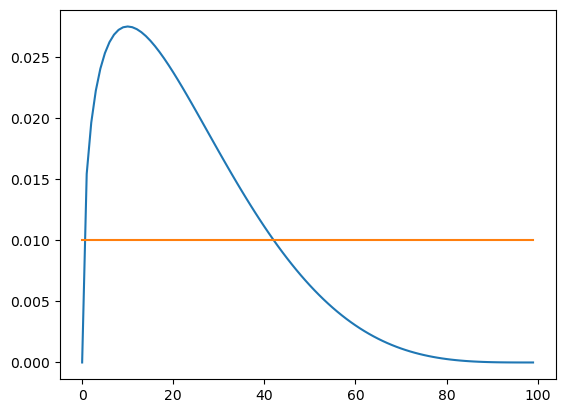

In [347]:
import matplotlib.pyplot as plt
import numpy as np

x_vec = np.arange(a,c,1)
vals = [p(x) for x in x_vec]
plt.plot(x_vec, vals)
plt.plot(x_vec, np.ones_like(x_vec) / len(x_vec))

### 1.1

In [348]:
def expected_value_integrand_p(x):
    return p(x) * x

def trapezoidal(fun, x0, xn, n):
    interval = (xn - x0) / n
    integral = 0
    
    x_prev = x0

    for x in np.arange(x0 + interval, xn + interval / 10, interval):
        integral += (x - x_prev)/2 * (fun(x) + fun(x_prev))

        x_prev = x

    return integral

for n in range(1,500):
    diff = np.abs(E - trapezoidal(expected_value_integrand_p, a, c, n)) 
    if diff < 5e-5:
        print(f"Difference between actual E[X] and approximated")
        print("---------------------------------------------------------")
        print(f"E[x] - E_hat[X] = {diff} using {n} samples")
        break

Difference between actual E[X] and approximated
---------------------------------------------------------
E[x] - E_hat[X] = 4.957722734388881e-05 using 271 samples


### 1.2 is done by hand

### 1.3

In [ ]:
np.random.seed(42)


for _ in range(10):
    n = 128053334

    estimates = []

    x = np.random.uniform(0,100, size=n)
    fx = 100 * expected_value_integrand_p(x)

    print(f"Average: {np.mean(fx) :.5f}")
    print(f"Std: {np.std(fx) / np.sqrt(n)}")

    # Actual diff
    diff = np.abs(np.mean(fx) - E)
    print(f"Diff: {diff}")

Average: 23.33247
Std: 0.005331664995230873
Diff: 0.0008619441550692386
Average: 23.32859
Std: 0.005331897598805585
Diff: 0.004746498873878124
Average: 23.34413
Std: 0.005331320137574944
Diff: 0.010800433569421841
Average: 23.32962
Std: 0.005331118398196652
Diff: 0.003710364801847277
Average: 23.33277
Std: 0.005332147149140096
Diff: 0.0005624561418855478
Average: 23.34238
Std: 0.005332540050111425
Diff: 0.009043649525775521
Average: 23.33599
Std: 0.0053314883257604105
Diff: 0.002656918700512989
Average: 23.33748
Std: 0.005332092182405697
Diff: 0.004146972905182622
Average: 23.33713
Std: 0.00533225726194065
Diff: 0.0038008532492739278
Average: 23.32939
Std: 0.005331854562277953
Diff: 0.003941364525129387


-0.031087913159705494


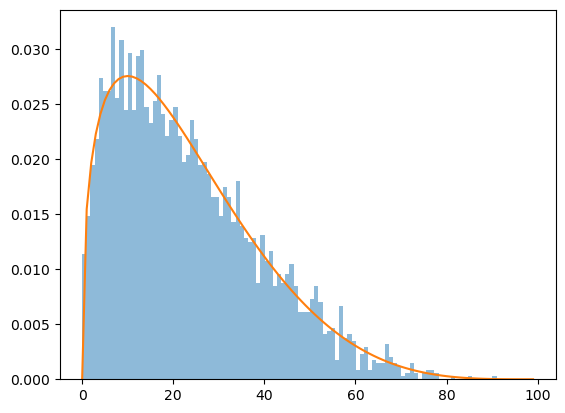

In [350]:
np.random.seed(42)
# Rejection sampling
M = 3
n = 11317

x = np.random.uniform(a,c, size=n)

u = np.random.uniform(0, M * 1 / (c -a), size=n)

# Accept 
accepted = u < p(x)
samples = x[accepted]

print(np.mean(samples) - E)

plt.hist(samples, bins=100, alpha=0.5, label='u samples', density=True)
plt.plot(x_vec, vals)
plt.show()

## Part 2

### 2.1

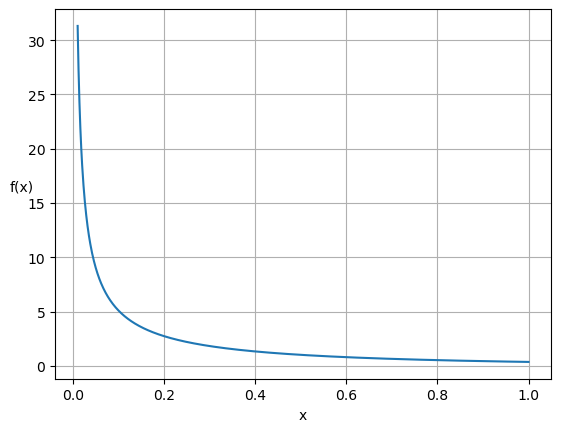

In [351]:
def integrand(x):
    return x**(-3/4) * np.exp(-x)

x = np.linspace(1e-2,1, 1000)
plt.plot(x, integrand(x))
plt.xlabel("x")
plt.ylabel("f(x)", rotation=0)
plt.grid(True)

### 2.2

In [352]:
np.random.seed(42)
n = 10**7

# estimates = []

for _ in range(10):
    x = np.random.uniform(0,1, size=n)
    fx = integrand(x)
    # estimates.append(np.mean(fx))
    
    print(f"{np.mean(fx)} +/- {np.std(fx) / np.sqrt(n)}")

# estimates = np.array(estimates)
# mean_estimate = np.mean(estimates)
# std_estimate = np.std(estimates)

# print(f"Average: {mean_estimate:.5f}")
# print(f"Standard deviation: {std_estimate:.5f}")


3.358766787316318 +/- 0.02620844516946836
3.285987749288469 +/- 0.023660974581962632
3.4207903442834726 +/- 0.06634129738738355
3.4831710924054757 +/- 0.10556382554836441
3.3377648062618053 +/- 0.03379518231008055
3.5080304977219203 +/- 0.20198770658959941
3.2544720116910506 +/- 0.016958891963915274
3.4400995683493942 +/- 0.10902066045137224
3.292697900578018 +/- 0.023452572670682733
3.257779094394792 +/- 0.0195474699750726


### 2.3

In [355]:
def q(x, c = 1/4):
    return c * x**(-3/4)

def q_cdf(x):
    return x**(1/4)

def q_cdf_inv(x):
    return x**4

np.random.seed(42)
n = 10**7
# estimates = []

for _ in range(10):
    u = np.random.uniform(0, 1, size=n)
    x = q_cdf_inv(u)  # samples from q(x)
    fx = integrand(x)
    qx = q(x)
    weights = fx / qx
    # estimates.append(np.mean(weights))

    print(f"{np.mean(weights)} +/- {np.std(weights) / np.sqrt(n)}")


# estimates = np.array(estimates)
# mean_estimate = np.mean(estimates)
# std_estimate = np.std(estimates)

# print(f"Average: {mean_estimate:.5f}")
# print(f"Standard deviation: {std_estimate:.5f}")


3.379397296533405 +/- 0.00023749080058554998
3.3792457215379885 +/- 0.0002375050547221714
3.379584219207786 +/- 0.000237494834900706
3.379746817735184 +/- 0.00023739981096722022
3.3793575230762527 +/- 0.00023755736824890463
3.379461281845539 +/- 0.00023754720129126288
3.3795818867019003 +/- 0.00023752168878923716
3.3793813036846907 +/- 0.00023755903567675978
3.3793414394387735 +/- 0.00023752452057294253
3.3795648742870696 +/- 0.00023747629328670905


### 2.4 - maybe make a graph of both with uncertainties

## 3

### 3.1